In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import random
from sklearn import metrics
%matplotlib inline

In [ ]:
from app.utils.HistogramEqualization import HistogramEqualization
from app.utils.ResNet34Model import ResNet34Model
from app.utils.VGG16Model import VGG16Model
from app.utils.EfficientNetModel import EfficientNetModel
from app.utils.ImageDataLoader import ImageDataLoader
from app.utils.ImageProcessor import ImageProcessor
from app.utils.DataExplorer import DataExplorer
from app.utils.DatasetStatistics import DatasetStatistics
from app.utils.DuplicateDetector import DuplicateDetector
from app.utils.OversampledDataset import OversampledDataset
from app.utils.BatchVisualizer import BatchVisualizer
from app.utils.Trainer import Trainer

In [ ]:
%run DatasetDivider.ipynb

In [17]:
TRAIN_DIR = "./new_data/Training"
VAL_DIR = "./new_data/Validation"
TEST_DIR = "./new_data/Testing"

BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)
NUMBER_OF_CLASSES = 4

FINAL_EPOCHS = 50
PATIENCE = 10

print(TRAIN_DIR, VAL_DIR, TEST_DIR)

./new_data/Training ./new_data/Validation ./new_data/Testing


In [18]:
def set_seed(seed=42):
    random.seed(seed)  # Python random
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU (used)
    torch.cuda.manual_seed_all(seed)  # PyTorch all GPUs
    torch.backends.cudnn.deterministic = True  # CUDA deterministic operations
    torch.backends.cudnn.benchmark = False  # Turn off autotuning for reproducity

In [19]:
device = (
    torch.accelerator.current_accelerator().type
    if torch.accelerator.is_available()
    else "cpu"
)
print(f"Using {device} device")
if device == "cuda":
    print(f"Accelerator name: {torch.cuda.get_device_name(device)}")
    torch.cuda.empty_cache()

Using cuda device
Accelerator name: NVIDIA GeForce RTX 5070 Ti


In [20]:
divider = DatasetDivider()
split_data = divider.run()

KeyboardInterrupt: 

In [7]:
loader = ImageDataLoader(TRAIN_DIR, VAL_DIR, TEST_DIR)
all_files = loader.load_all_images()

print(f"Successfully loaded {len(all_files)} images")

Successfully loaded 3027 images


In [8]:
duplicate_detector = DuplicateDetector(all_files)
duplicate_detector.detect_duplicates()

if len(duplicate_detector.duplicates) > 0:  # If duplicate files are present
    duplicate_detector.remove_duplicates_from_disk()  # Removing duplicates entirely from disk
    all_files = duplicate_detector.get_unique_files()  # Cleaning list with file paths


Checking 3027 files for duplicates...
Checked 100 out of 3027 files
Checked 200 out of 3027 files
Checked 300 out of 3027 files
Checked 400 out of 3027 files
Checked 500 out of 3027 files
Checked 600 out of 3027 files
Checked 700 out of 3027 files
Checked 800 out of 3027 files
Checked 900 out of 3027 files
Checked 1000 out of 3027 files
Checked 1100 out of 3027 files
Checked 1200 out of 3027 files
Checked 1300 out of 3027 files
Checked 1400 out of 3027 files
Checked 1500 out of 3027 files
Checked 1600 out of 3027 files
Checked 1700 out of 3027 files
Checked 1800 out of 3027 files
Checked 1900 out of 3027 files
Checked 2000 out of 3027 files
Checked 2100 out of 3027 files
Checked 2200 out of 3027 files
Checked 2300 out of 3027 files
Checked 2400 out of 3027 files
Checked 2500 out of 3027 files
Checked 2600 out of 3027 files
Checked 2700 out of 3027 files
Checked 2800 out of 3027 files
Checked 2900 out of 3027 files
Checked 3000 out of 3027 files
SUMMARY: Found 0 duplicate files


In [9]:
loader.print_dataset_class_count()

Training folder details:
	glioma_tumor: 631 images
	meningioma_tumor: 649 images
	no_tumor: 246 images
	pituitary_tumor: 592 images
Validation folder details:
	glioma_tumor: 135 images
	meningioma_tumor: 139 images
	no_tumor: 53 images
	pituitary_tumor: 127 images
Testing folder details:
	glioma_tumor: 136 images
	meningioma_tumor: 139 images
	no_tumor: 53 images
	pituitary_tumor: 127 images



Loading 3027 images and converting to grayscale...
  Progress: 1/3027 images
  Progress: 500/3027 images
  Progress: 1000/3027 images
  Progress: 1500/3027 images
  Progress: 2000/3027 images
  Progress: 2500/3027 images
  Progress: 3000/3027 images
Images loaded


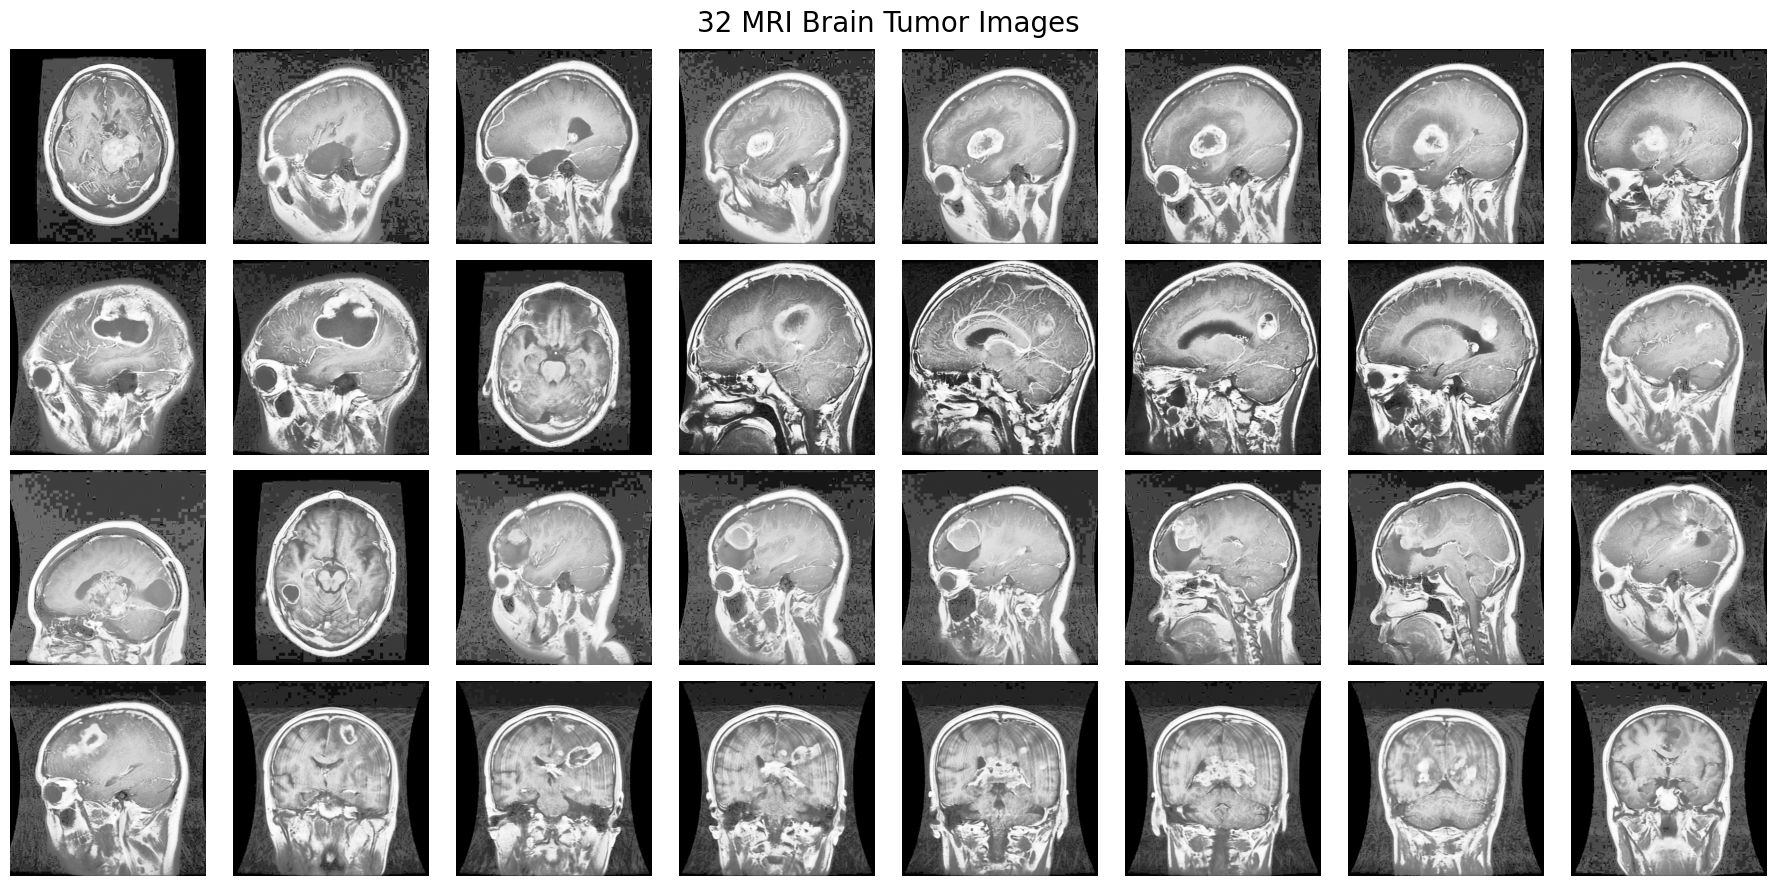

In [10]:
processor = ImageProcessor(all_files)

processor.load_grayscale_images(equalize=True)
processor.display_image_grid(batch_size=32, figsize=(18, 9), images_per_row=8)

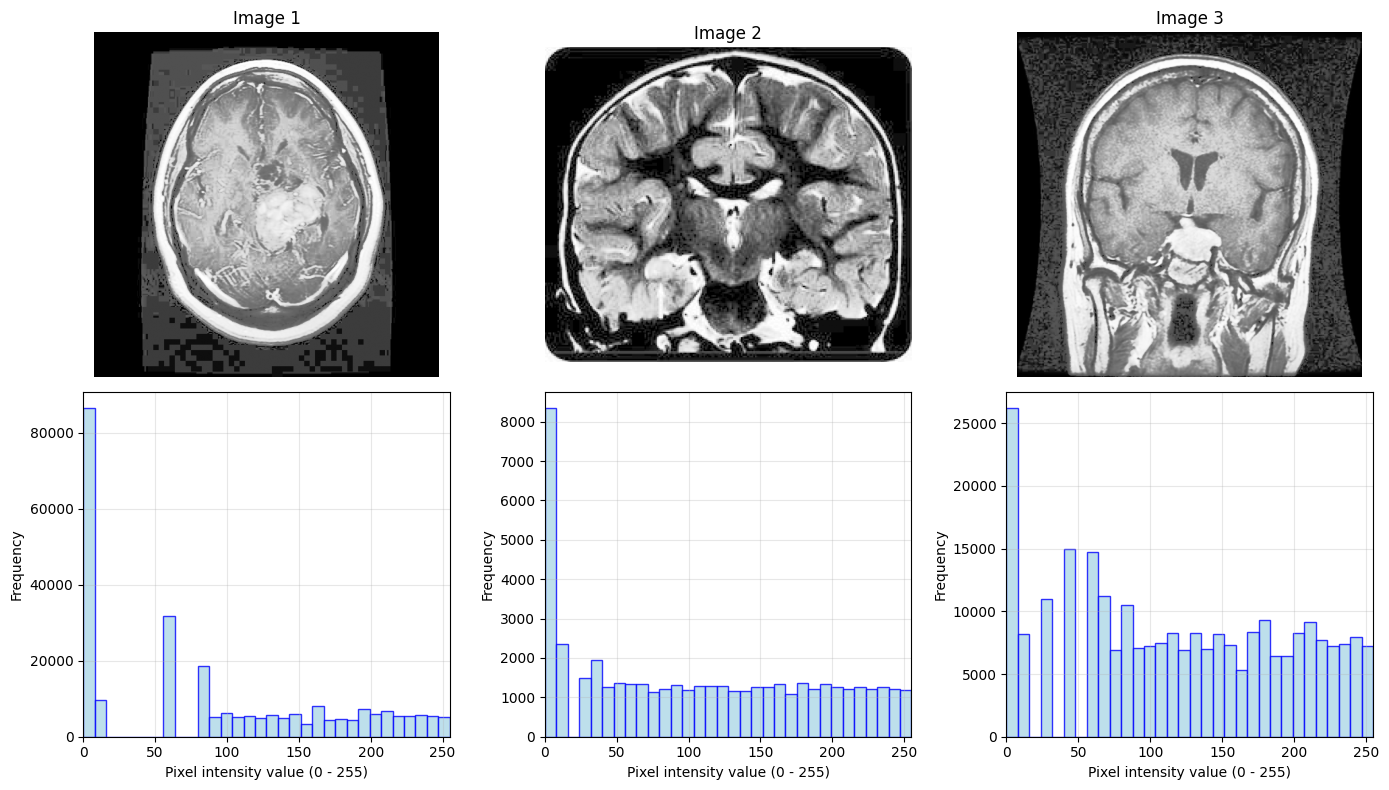

In [11]:
explorator = DataExplorer(all_files)
explorator.retrieve_sample_of_images(
    [0, len(all_files) // 2, -1], equalize=True
)  # First, middle and last image

explorator.plot_histogram()

In [12]:
stats = DatasetStatistics(processor.gray_images)

stats.compute_stats()
stats.print_stats()

MEAN, STD = stats.get_normalized_values()

KeyboardInterrupt: 

In [ ]:
print()

In [ ]:
train_transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        HistogramEqualization(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(12),
        transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[MEAN] * 3, std=[STD] * 3),
    ]
)

In [ ]:
test_transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        HistogramEqualization(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[MEAN] * 3, std=[STD] * 3),
    ]
)

In [ ]:
trainset = OversampledDataset(TRAIN_DIR, transform=train_transform)
valset = datasets.ImageFolder(VAL_DIR, transform=test_transform)
testset = datasets.ImageFolder(TEST_DIR, transform=test_transform)

print()
trainset.print_class_distribution()

print()
print(f"Training samples: {len(trainset)}")
print(f"Validation samples: {len(valset)}")
print(f"Test samples: {len(testset)}")
print(f"Classes: {trainset.classes}")

In [ ]:
g = torch.Generator()
g.manual_seed(42)

train_dl = DataLoader(trainset, BATCH_SIZE, shuffle=True, num_workers=0, generator=g)
val_dl = DataLoader(valset, BATCH_SIZE, shuffle=False, num_workers=0)
test_dl = DataLoader(testset, BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
models_config = {
    "VGG-16": VGG16Model,
    "ResNet34": ResNet34Model,
    "EfficientNet_B0": EfficientNetModel,
}

optimizers_config = {
    "sgd": lambda params, lr: optim.SGD(params, lr=lr),
    "sgd_momentum": lambda params, lr: optim.SGD(params, lr=lr, momentum=0.9),
    "adam": lambda params, lr: optim.Adam(params, lr=lr),
}

LEARNING_RATES = [0.01, 0.001, 0.0001, 0.00001]

In [ ]:
EPOCHS = 5

In [ ]:
def run_experiment(
    model_class, optimizer_fn, lr, train_dl, val_dl, device, epochs=EPOCHS
):
    set_seed(42)

    model = model_class(NUMBER_OF_CLASSES)
    trainer = Trainer(model, device)
    optimizer = optimizer_fn(model.parameters(), lr)

    history = trainer.fit(train_dl, val_dl, optimizer, epochs)

    return {
        "last_epoch_val_acc": history["val_acc"][-1],
        "best_val_acc": max(history["val_acc"]),
        "last_epoch_val_loss": history["val_loss"][-1],
        "history": history,
    }


def run_all_experiments(train_dl, val_dl, device):
    res = []

    total = len(models_config) * len(optimizers_config) * len(LEARNING_RATES)
    current = 0

    for model_name, model_class in models_config.items():
        for optim_name, optim_fn in optimizers_config.items():
            for lr in LEARNING_RATES:
                current += 1
                print(f"\n[{current}/{total}] {model_name} + {optim_name} + lr={lr}")

                result = run_experiment(
                    model_class, optim_fn, lr, train_dl, val_dl, device
                )

                res.append(
                    {
                        "model": model_name,
                        "optimizer": optim_name,
                        "learning rate": lr,
                        **result,
                    }
                )
                print(
                    f"Last epoch's validation accuracy: {result['last_epoch_val_acc']:.4f}"
                )

    return res

In [ ]:
results = run_all_experiments(train_dl, val_dl, device)

In [ ]:
vgg16_model = VGG16Model(NUMBER_OF_CLASSES)
optimizer_vgg16 = optim.Adam(vgg16_model.parameters(), lr=0.0001)

trainer_vgg16 = Trainer(vgg16_model, device)
vgg16_history = trainer_vgg16.fit(
    train_dl, val_dl, optimizer_vgg16, FINAL_EPOCHS, PATIENCE
)
vgg16_acc, vgg16_preds, vgg16_labels = trainer_vgg16.test(test_dl)

In [ ]:
print("#" * 20 + " VGG-16 CLASSIFICATION STATISTICS " + "#" * 20)
print()

print(
    metrics.classification_report(
        vgg16_labels, vgg16_preds, target_names=testset.classes
    )
)

In [ ]:
set_seed(42)

resnet34_model = ResNet34Model()
optimizer_resnet = optim.SGD(resnet34_model.parameters(), lr=0.001, momentum=0.9)

trainer_resnet34 = Trainer(resnet34_model, device)
resnet34_history = trainer_resnet34.fit(
    train_dl, val_dl, optimizer_resnet, FINAL_EPOCHS, PATIENCE
)
resnet34_acc, resnet34_preds, resnet34_labels = trainer_resnet34.test(test_dl)

In [ ]:
print("#" * 20 + " RESNET34 CLASSIFICATION STATISTICS " + "#" * 20)
print()

print(
    metrics.classification_report(
        resnet34_labels, resnet34_preds, target_names=testset.classes
    )
)

In [ ]:
set_seed(42)

efficientnet_model = EfficientNetModel()
optimizer_efficientnet = optim.Adam(efficientnet_model.parameters(), lr=0.001)

trainer_efficientnet = Trainer(efficientnet_model, device)
efficientnet_history = trainer_efficientnet.fit(
    train_dl, val_dl, optimizer_efficientnet, FINAL_EPOCHS, PATIENCE
)
efficientnet_acc, efficientnet_preds, efficientnet_labels = trainer_efficientnet.test(
    test_dl
)

In [ ]:
print("#" * 20 + " EFFICIENTNET CLASSIFICATION STATISTICS " + "#" * 20)
print()

print(
    metrics.classification_report(
        efficientnet_labels, efficientnet_preds, target_names=testset.classes
    )
)

In [ ]:
def plot_train_val_accuracy(train_acc, val_acc, title=None, ax=None):
    if ax is None:
        _, ax = plt.subplots()

    ax.plot(train_acc, "r--", label="Training accuracy")
    ax.plot(val_acc, "b-", label="Validation accuracy")

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    if title is not None:
        ax.set_title(title, fontsize=10)

    ax.grid()
    ax.legend()


def plot_train_val_loss(train_loss, val_loss, title=None, ax=None):
    if ax is None:
        _, ax = plt.subplots()

    ax.plot(train_loss, "g--", label="Training loss")
    ax.plot(val_loss, "m-", label="Validation loss")

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    if title is not None:
        ax.set_title(title, fontsize=10)

    ax.grid()
    ax.legend()

In [ ]:
_, axs = plt.subplots(ncols=3, figsize=(15, 5))
plot_train_val_accuracy(
    vgg16_history["train_acc"], vgg16_history["val_acc"], "VGG-16 model", axs[0]
)

plot_train_val_accuracy(
    resnet34_history["train_acc"], resnet34_history["val_acc"], "ResNet34 model", axs[1]
)

plot_train_val_accuracy(
    efficientnet_history["train_acc"],
    efficientnet_history["val_acc"],
    "EfficientNet model",
    axs[2],
)

plt.suptitle("Models training accuracy vs validation accuracy", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
_, axs = plt.subplots(ncols=3, figsize=(15, 5))
plot_train_val_loss(
    vgg16_history["train_loss"], vgg16_history["val_loss"], "VGG-16 model", axs[0]
)

plot_train_val_loss(
    resnet34_history["train_loss"],
    resnet34_history["val_loss"],
    "ResNet34 model",
    axs[1],
)

plot_train_val_loss(
    efficientnet_history["train_loss"],
    efficientnet_history["val_loss"],
    "EfficientNet model",
    axs[2],
)

plt.suptitle("Models training loss vs validation loss", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
results = [
    [vgg16_labels, vgg16_preds],
    [resnet34_labels, resnet34_preds],
    [efficientnet_labels, efficientnet_preds],
]

_, axs = plt.subplots(ncols=3, figsize=(28, 8))
i = 0

for model in models_config:
    cm = metrics.confusion_matrix(results[i][0], results[i][1])
    cm_display = metrics.ConfusionMatrixDisplay(cm, display_labels=testset.class_to_idx)
    cm_display.plot(cmap="Blues", ax=axs[i], text_kw={"fontsize": 14})

    axs[i].set_title(f"{model} confusion matrix", y=1.02, fontsize=18)

    axs[i].tick_params(axis="x", rotation=45, labelsize=12)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), ha="right")

    axs[i].tick_params(axis="y", labelsize=12)

    axs[i].set_xlabel("Predicted label", fontsize=14)
    axs[i].set_ylabel("True label", fontsize=14)

    i += 1

plt.suptitle("Confusion matrix for all models", fontsize="22", y=1.05)
plt.tight_layout()
plt.show()

In [ ]:
# TODO: consider other way to oversample classes (no tumor has nearly ¬500 samples, where rest of the classes are >= 600)

In [ ]:
# CHOSEN MODEL: ResNet34 + sgd_momentum + lr=0.001 WITH collorJitter settings at .15 and histogram equalization

In [ ]:
checkpoint = {
    "weights": trainer_resnet34.model.state_dict(),
    "mean": MEAN,
    "std": STD,
    "image_size": IMAGE_SIZE,
    "hist_eq": True,
}
# torch.save(checkpoint, "./config/resnet34.pth")